In [149]:
# Import libraries
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from wordcloud import WordCloud
import data_providing as dp

In [150]:
# Download NLTK stopwords dataset
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [151]:
# Load data
train, test, title_brand = dp.load_sentiment_analysis_data()

/content/data_providing.py:86: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  train_data = pd.read_csv(train_data_path)


In [152]:
# Check shape of datasets
print(f"train shape: {train.shape}")
print(f"test shape: {train.shape}")
print(f"title_brand shape: {title_brand.shape}")

train shape: (838944, 11)
test shape: (838944, 11)
title_brand shape: (786445, 3)


In [153]:
# Take a look at some samples from train dataset
train.sample(3)

,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime
292470,4,NaN,True,2018-01-28,A9WRUDPE177HJ,B00KXYXXK2,NaN,Q1,"Works well, takes a bit long to turn off and o...","Pretty Big Unit, Connection is Good, Quality o...",1517097600
304174,5,NaN,True,2017-07-27,A3GPFDB50LSZ34,B00LP6CFEC,{'Color:': ' Black/Green'},Mike,These earbuds are awesome!! Great sound qualit...,These earbuds are awesome!!,1501113600
812888,5,NaN,True,2016-04-16,A2O4Y3QOPHS6H5,B013HNYVFG,NaN,Lars Slate,As some one who owns 70 or 80 drives ( all run...,... 70 or 80 drives ( all running) WD makes gr...,1460764800


In [154]:
# Take a look at some samples from title_brand dataset
title_brand.sample(3)

,asin,title,brand
170443,B002NCBV6U,Masscool Fd09025b1m34 90mm 3/4 Pin Ball Beari...,Masscool Cpu fan
691552,B016XKANLG,"iPad 5, iPad Air Case- Kids Light Weight Kido ...",TRAVELLOR
629453,B00XLUXG70,Paris Eiffel Tower Design - Universal 8&quot; ...,icell


In [155]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 838944 entries, 0 to 838943
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   overall         838944 non-null  int64 
 1   vote            191468 non-null  object
 2   verified        838944 non-null  bool  
 3   reviewTime      838944 non-null  object
 4   reviewerID      838944 non-null  object
 5   asin            838944 non-null  object
 6   style           490613 non-null  object
 7   reviewerName    838742 non-null  object
 8   reviewText      838944 non-null  object
 9   summary         838869 non-null  object
 10  unixReviewTime  838944 non-null  int64 
dtypes: bool(1), int64(2), object(8)
memory usage: 64.8+ MB


In [156]:
# Check missing values in train dataset
print("Missing vlaues rate in train dataset:")
print((train.isnull().mean() * 100).round(3).astype('str') + '%')

Missing vlaues rate in train dataset:
overall              0.0%
vote              77.177%
verified             0.0%
reviewTime           0.0%
reviewerID           0.0%
asin                 0.0%
style              41.52%
reviewerName       0.024%
reviewText           0.0%
summary            0.009%
unixReviewTime       0.0%
dtype: object


In [157]:
# Check missing values in test dataset
print("Missing vlaues rate in test dataset:")
print((test.isnull().mean() * 100).round(3).astype('str') + '%')

Missing vlaues rate in test dataset:
vote              75.335%
verified             0.0%
reviewTime           0.0%
reviewerID           0.0%
asin                 0.0%
style              42.48%
reviewerName        0.02%
reviewText           0.0%
summary             0.01%
unixReviewTime       0.0%
dtype: object


In [158]:
# Check missing values in title_brand dataset
print("Missing vlaues rate in title_brand dataset:")
print((title_brand.isnull().mean() * 100).round(3).astype('str') + '%')

Missing vlaues rate in title_brand dataset:
asin       0.0%
title    0.002%
brand    0.691%
dtype: object


In [159]:
### Some preprocessing ###

# Drop some rows wiht missing values
train.dropna(subset=['summary', 'reviewerName'], inplace=True)
test.dropna(subset=['summary', 'reviewerName'], inplace=True)

# Drop some useless columns
train.drop(['unixReviewTime', 'style'], axis=1, inplace=True)
test.drop(['unixReviewTime', 'style'], axis=1, inplace=True)

# Change type of overall to int8 to save memory
train['overall'] = train['overall'].astype('int8')

# Change type of vote to int
train['vote'] = pd.to_numeric(train['vote'], errors='coerce', downcast='integer')
train['vote'] = train['vote'].fillna(pd.NA).astype('Int32')

test['vote'] = pd.to_numeric(test['vote'], errors='coerce', downcast='integer')
test['vote'] = test['vote'].fillna(pd.NA).astype('Int32')

# Change reviewTime type
train['reviewTime'] = pd.to_datetime(train['reviewTime'])
test['reviewTime'] = pd.to_datetime(test['reviewTime'])

# Sort by reviewTime
train.sort_values(by='reviewTime', axis=0, inplace=True, ascending=True)
test.sort_values(by='reviewTime', axis=0, inplace=True, ascending=True)

# Reset index
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

In [160]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 838667 entries, 0 to 838666
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   overall       838667 non-null  int8          
 1   vote          191375 non-null  Int32         
 2   verified      838667 non-null  bool          
 3   reviewTime    838667 non-null  datetime64[ns]
 4   reviewerID    838667 non-null  object        
 5   asin          838667 non-null  object        
 6   reviewerName  838667 non-null  object        
 7   reviewText    838667 non-null  object        
 8   summary       838667 non-null  object        
dtypes: Int32(1), bool(1), datetime64[ns](1), int8(1), object(5)
memory usage: 44.0+ MB


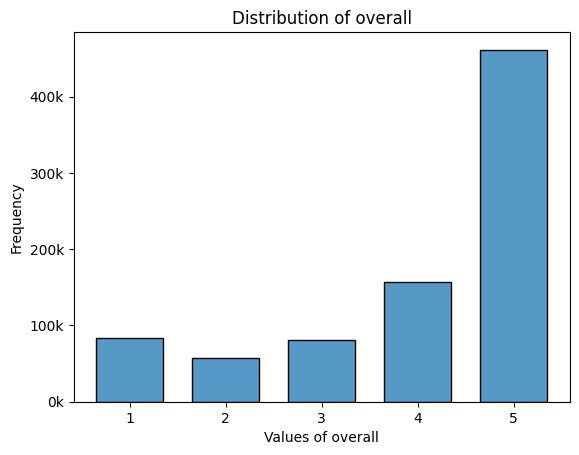

In [161]:
# Distribution of the target(=overall)
sns.histplot(train, x='overall', discrete=True, shrink=0.7)
plt.gca().yaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, _: f'{int(x / 1000)}k'))
plt.ylabel('Frequency')
plt.xlabel('Values of overall')
plt.title('Distribution of overall')
plt.show()

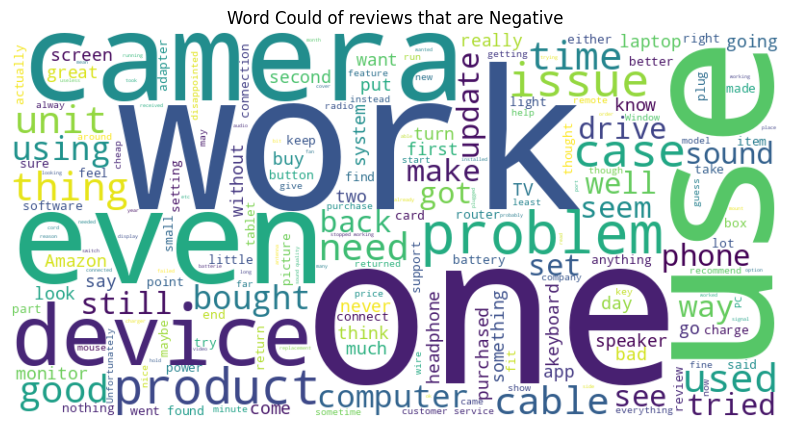

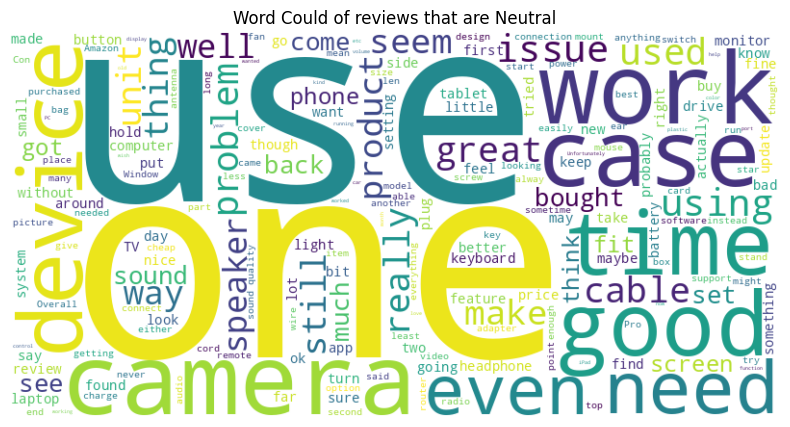

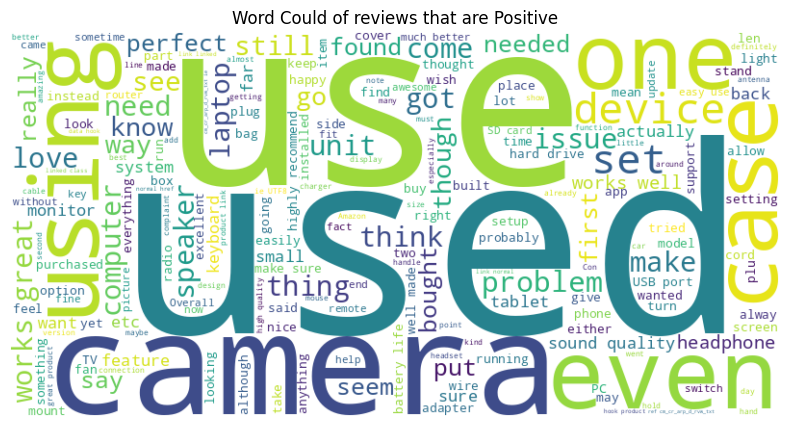

In [162]:
### Plot word cloud of reviews ###

# Decode overall
overall_decoder = {
    1: 'Negative',
    2: 'Negative',
    3: 'Neutral',
    4: 'Positive',
    5: 'Positive',
}
train["overall (decoded)"] = train['overall'].map(overall_decoder)

# Get the list of English stop words
stop_words = set(stopwords.words('english'))

# Sample train dataset
st = train.groupby("overall", group_keys=False).apply(
    lambda x: x.sample(frac=0.3)
)

# Group (sample)reviews by overall
reviews_grouped = st.groupby("overall (decoded)")['reviewText'].agg(' '.join)

# Remove stop words from reviewText
reviews_grouped_trimmed = reviews_grouped.apply(
    lambda reviews: ' '.join(
        [word for word in reviews.split() if word.lower() not in stop_words]))

# Plot word could for each overall group
for group, text in reviews_grouped_trimmed.items():
  wc = WordCloud(width=800, height=400, background_color='white').generate(text)
  plt.figure(figsize=(10, 5))
  plt.imshow(wc, interpolation='bilinear')
  plt.title(f'Word Could of reviews that are {group}')
  plt.axis('off')
plt.show()

# Delete some variables to free memory
del reviews_grouped, reviews_grouped_trimmed

In [163]:
### Top 10 reviewers with most votes ###
votes_by_reviewer = train.groupby(['reviewerID', 'reviewerName'])['vote'].sum()
votes_by_reviewer = votes_by_reviewer.to_frame().reset_index()
top_10_reviewers = votes_by_reviewer.sort_values(by='vote', ascending=False)[:10]
top_10_reviewers

,reviewerID,reviewerName,vote
98734,A25GROL6KJV3QG,Benson Leung,4572
129947,A2IK776FY6MEMG,Obi Wan,1608
24237,A1A39899KH5QCI,Chris Winter,1352
293334,AMYCUX8EWEUVV,Mayra S.,1342
261384,A9K7V1MKJ9BOJ,VermontGuy,1337
73232,A1UQUDT2Q0YENM,Michael,1230
235611,A3R1WFO4KIUQXZ,PhotoGraphics,1209
169647,A2Z9APP5B09MFY,Nicholas,1188
296758,AOEAD7DPLZE53,NLee the Engineer,1103
323642,AZPCDY9OQ605E,David H,1045


In [164]:
del votes_by_reviewer

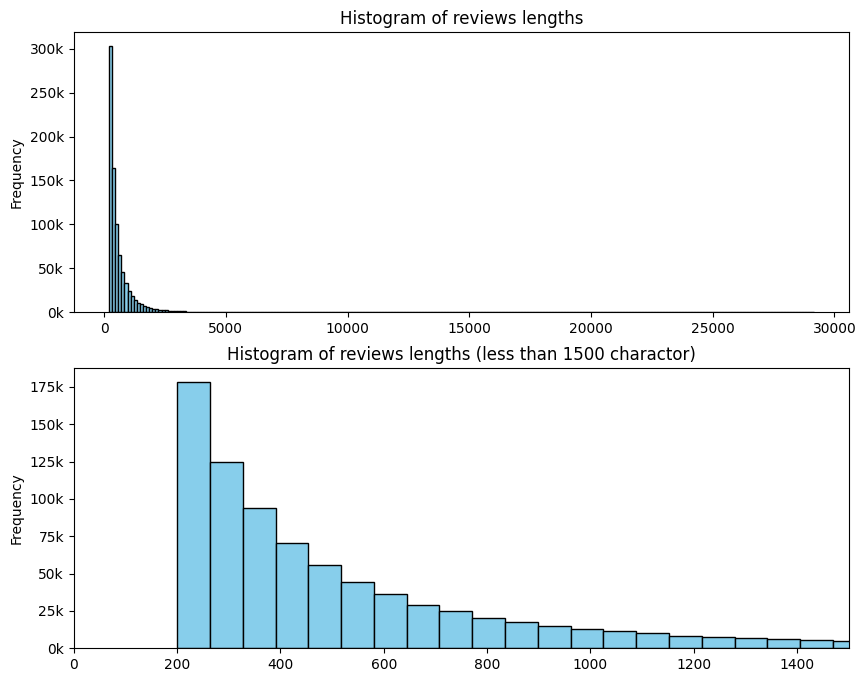

In [165]:
### histogram of (sample)reviews length ####

# Calculate (sample)reviews lengths
reviews_lengths = train.reviewText.map(lambda review: len(review))

# Plot histogram of (sample)reviews length
fig, axes = plt.subplots(2, 1, figsize=(10, 8))
num_bins = int(np.sqrt(len(reviews_lengths))) // 4
axes[0].hist(reviews_lengths, bins=num_bins, color='skyblue', edgecolor='black')
axes[0].set_title('Histogram of reviews lengths')
axes[0].yaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, _: f'{int(x / 1000)}k'))
axes[0].set_ylabel('Frequency')

# Ignore reviews with too high length (more than 1500 charactor)
axes[1].hist(reviews_lengths, bins=2*num_bins, color='skyblue', edgecolor='black')
axes[1].set_title("Histogram of reviews lengths (less than 1500 charactor)")
axes[1].yaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, _: f'{int(x / 1000)}k'))
axes[1].set_xlim(0, 1500)
axes[1].set_ylabel('Frequency')

plt.show()

In [166]:
### Products with most 5 overalls ###
overall_5_counts = train[train.overall == 5].groupby('asin')['overall'].size()
overall_5_counts = overall_5_counts.to_frame().reset_index()
top_10_products = overall_5_counts.sort_values(by='overall', ascending=False)[:10]
top_10_products.columns = ['asin', 'overall 5 counts']
top_10_products = pd.merge(title_brand, top_10_products, on='asin', how='inner')
top_10_products.drop('asin', axis=1, inplace=True)
top_10_products.sort_values(by="overall 5 counts", ascending=False, inplace=True)
top_10_products

,title,brand,overall 5 counts
8,OontZ Angle 3 Enhanced Stereo Edition IPX5 Spl...,Cambridge Soundworks,1162
3,NETGEAR N300 WiFi Range Extender (EX2700),NETGEAR,659
9,Roku Streaming Stick (3600R) - HD Streaming Pl...,Roku,600
0,StarTech USB 2.0 to SATA IDE Adapter (USB2SATA...,StarTech,598
2,Logitech M570 Wireless Trackball Mouse &ndash;...,Logitech,552
5,Samsung 850 EVO 500GB 2.5-Inch SATA III Intern...,Samsung,529
7,ASUS Tri-Band Gigabit (AC3200) WiFi Router (Up...,Asus,471
1,VideoSecu ML531BE TV Wall Mount for Most 27&qu...,VideoSecu,448
6,Arlo - Wireless Home Security Camera System | ...,"Arlo Technologies, Inc",433
4,Samsung 850 EVO 250GB 2.5-Inch SATA III Intern...,Samsung,431


In [167]:
### Top brands with most overall mean ###
df_merged = pd.merge(title_brand, train, on='asin', how='inner')
review_counts_by_brand = df_merged.groupby('brand')['reviewText'].size()
review_counts_by_brand = review_counts_by_brand.to_frame().reset_index()
review_counts_by_brand.columns = ['brand', 'review counts']
review_counts_by_brand.sort_values(by='review counts', ascending=False, inplace=True)
top_10_brands = review_counts_by_brand[:10]
df_merged = pd.merge(top_10_brands, df_merged, on='brand', how='inner')
top_10_brands = df_merged.groupby('brand')['overall'].mean().to_frame()
top_10_brands = top_10_brands.reset_index()
top_10_brands.columns = ['brand', 'overall mean']
top_10_brands.sort_values(by='overall mean', ascending=False, inplace=True)
top_10_brands

,brand,overall mean
1,Anker,4.244801
0,AmazonBasics,4.201226
5,Sabrent,4.028025
7,SanDisk,3.958805
3,Logitech,3.953989
6,Samsung,3.941635
8,Sony,3.939119
9,TP-LINK,3.928564
2,Asus,3.855454
4,NETGEAR,3.836181
